In [1]:
from structure.gapartnet import ObjIns
from structure.gapartnet import save_point_cloud_to_ply
import glob, os, sys, json, pickle
from PIL import Image
import numpy as np
import tqdm
PART_ID2NAME = {
    0: 'others'             ,
    1: 'line_fixed_handle'  ,
    2: 'round_fixed_handle' ,
    3: 'slider_button'      ,
    4: 'hinge_door'         ,
    5: 'slider_drawer'      ,
    6: 'slider_lid'         ,
    7: 'hinge_lid'          ,
    8: 'hinge_knob'         ,
    9: 'revolute_handle'    ,
}
camera_poses = [
    (30, 120, 4),
    (30, 240, 4),
    (45, 180, 4),
    (60, 180, 4),
    (80, 120, 4),
    (80, 240, 4),
    # (1, 90, 4.5),
    # (90, 90, 4.5),
    # (45, 90, 4.5),
    # (135, 90, 4.5),
    # (170, 90, 4.5),
    # (90, 0, 4.5),
    # (90, 90, 4.5),
    # (90, 45, 4.5),
    # (90, 135, 4.5),
]
TEST_ROOT = "./test"

In [2]:

import os
import sys
from os.path import join as pjoin
import numpy as np
from argparse import ArgumentParser
import glob
from dataset.render_tools.utils.config_utils import PARTNET_DATASET_PATH, AKB48_DATASET_PATH, PARTNET_ID_PATH, AKB48_ID_PATH, PARTNET_CAMERA_POSITION_RANGE, \
    AKB48_CAMERA_POSITION_RANGE, TARGET_GAPARTS, BACKGROUND_RGB, SAVE_PATH
from dataset.render_tools.utils.read_utils import get_id_category, read_joints_from_urdf_file, save_rgb_image, save_depth_map, save_anno_dict, save_meta
from dataset.render_tools.utils.render_utils import get_cam_pos, get_cam_pos_fix, set_all_scene, render_rgb_image, render_depth_map, \
    render_sem_ins_seg_map, add_background_color_for_image, get_camera_pos_mat, merge_joint_qpos
from dataset.render_tools.utils.pose_utils import query_part_pose_from_joint_qpos, get_NPCS_map_from_oriented_bbox

PARTNET_ID_PATH = "./dataset/render_tools/meta/partnet_all_id_list.txt"
DATA_ROOT = "./example_assets"
PARTNET_DATASET_PATH = DATA_ROOT
SAVE_PATH = './example_rendered'

def render_one_image(
        dataset_name, model_id, camera_idx, 
        render_idx, height, width, use_raytracing=False, 
        replace_texture=False, add_name = "", cam_pose = None,
        joint_qpos = None):
    
    # 1. read the id list to get the category; set path, camera range, and base link name
    if dataset_name == 'partnet':
        category = get_id_category(model_id, PARTNET_ID_PATH)
        if category is None:
            raise ValueError(f'Cannot find the category of model {model_id}')
        data_path = pjoin(PARTNET_DATASET_PATH, str(model_id))
        camera_position_range = PARTNET_CAMERA_POSITION_RANGE
        base_link_name = 'base'
        
    elif dataset_name == 'akb48':
        category = get_id_category(model_id, AKB48_ID_PATH)
        if category is None:
            raise ValueError(f'Cannot find the category of model {model_id}')
        data_path = pjoin(AKB48_DATASET_PATH, category, str(model_id))
        camera_position_range = AKB48_CAMERA_POSITION_RANGE
        base_link_name = 'root'
    
    else:
        raise ValueError(f'Unknown dataset {dataset_name}')
    
    # 2. read the urdf file,  get the kinematic chain, and collect all the joints information
    joints_dict = read_joints_from_urdf_file(data_path, 'mobility_annotation_gapartnet.urdf')
    
    # 3. generate the joint qpos randomly in the limit range
    if joint_qpos is None:
        joint_qpos = {}
        for joint_name in joints_dict:
            joint_type = joints_dict[joint_name]['type']
            # joint_qpos[joint_name] = 0
            if joint_type == 'prismatic' or joint_type == 'revolute':
                joint_limit = joints_dict[joint_name]['limit']
                joint_qpos[joint_name] = np.random.uniform(joint_limit[0], joint_limit[1])
            elif joint_type == 'fixed':
                joint_qpos[joint_name] = 0.0  # ! the qpos of fixed joint must be 0.0
            elif joint_type == 'continuous':
                joint_qpos[joint_name] = np.random.uniform(-10000.0, 10000.0)
            else:
                raise ValueError(f'Unknown joint type {joint_type}')
    else:
        pass
    # 4. generate the camera pose randomly in the specified range
    camera_range = camera_position_range[category][camera_idx]
    camera_pos = get_cam_pos_fix(
        cam_pose[0], cam_pose[1], cam_pose[2],
    )
    # 5. pass the joint qpos and the augmentation parameters to set up render environment and robot
    scene, camera, engine, robot = set_all_scene(data_path=data_path, 
                                        urdf_file='mobility_annotation_gapartnet.urdf',
                                        cam_pos=camera_pos,
                                        width=width, 
                                        height=height,
                                        use_raytracing=False,
                                        joint_qpos_dict=joint_qpos)
    
    # 6. use qpos to calculate the gapart poses
    link_pose_dict = query_part_pose_from_joint_qpos(data_path=data_path, anno_file='link_annotation_gapartnet.json', joint_qpos=joint_qpos, joints_dict=joints_dict, target_parts=TARGET_GAPARTS, base_link_name=base_link_name, robot=robot)
    
    # 7. render the rgb, depth, mask, valid(visible) gapart
    rgb_image = render_rgb_image(camera=camera)
    depth_map = render_depth_map(camera=camera)
    sem_seg_map, ins_seg_map, valid_linkName_to_instId = render_sem_ins_seg_map(scene=scene, camera=camera, link_pose_dict=link_pose_dict, depth_map=depth_map)
    valid_link_pose_dict = {link_name: link_pose_dict[link_name] for link_name in valid_linkName_to_instId.keys()}
    
    # 8. acquire camera intrinsic and extrinsic matrix
    camera_intrinsic, world2camera_rotation, camera2world_translation = get_camera_pos_mat(camera)
    
    # 9. calculate NPCS map
    valid_linkPose_RTS_dict, valid_NPCS_map = get_NPCS_map_from_oriented_bbox(depth_map, ins_seg_map, valid_linkName_to_instId, valid_link_pose_dict, camera_intrinsic, world2camera_rotation, camera2world_translation)
    
    # 10. (optional, only for [partnet] dataset) use texture to render rgb to replace the previous rgb (texture issue during cutting the mesh)
    if replace_texture:
        assert dataset_name == 'partnet', 'Texture replacement is only needed for PartNet dataset'
        texture_joints_dict = read_joints_from_urdf_file(data_path, 'mobility_texture_gapartnet.urdf')
        texture_joint_qpos = merge_joint_qpos(joint_qpos, joints_dict, texture_joints_dict)
        scene, camera, engine, robot = set_all_scene(data_path=data_path, 
                                        urdf_file='mobility_texture_gapartnet.urdf',
                                        cam_pos=camera_pos,
                                        width=width, 
                                        height=height,
                                        use_raytracing=use_raytracing,
                                        joint_qpos_dict=texture_joint_qpos,
                                        engine=engine)
        rgb_image = render_rgb_image(camera=camera)
    
    # 11. add background color
    rgb_image = add_background_color_for_image(rgb_image, depth_map, BACKGROUND_RGB)
    
    # 12. save the rendered results
    
    save_name = f"{category}_{model_id}_{camera_idx}_{render_idx}_{add_name}"
    if not os.path.exists(SAVE_PATH):
        os.mkdir(SAVE_PATH)
    
    save_rgb_image(rgb_image, SAVE_PATH, save_name)
    
    save_depth_map(depth_map, SAVE_PATH, save_name)
    
    bbox_pose_dict = {}
    for link_name in valid_link_pose_dict:
        bbox_pose_dict[link_name] = {
            'bbox': valid_link_pose_dict[link_name]['bbox'],
            'category_id': valid_link_pose_dict[link_name]['category_id'],
            'instance_id': valid_linkName_to_instId[link_name],
            'pose_RTS_param': valid_linkPose_RTS_dict[link_name],
        }
    anno_dict = {
        'semantic_segmentation': sem_seg_map,
        'instance_segmentation': ins_seg_map,
        'npcs_map': valid_NPCS_map,
        'bbox_pose_dict': bbox_pose_dict,
    }
    save_anno_dict(anno_dict, SAVE_PATH, save_name)
    
    metafile = {
        'model_id': model_id,
        'category': category,
        'camera_idx': camera_idx,
        'render_idx': render_idx,
        'width': width,
        'height': height,
        'joint_qpos': joint_qpos,
        'camera_pos': camera_pos.reshape(-1).tolist(),
        'camera_intrinsic': camera_intrinsic.reshape(-1).tolist(),
        'world2camera_rotation': world2camera_rotation.reshape(-1).tolist(),
        'camera2world_translation': camera2world_translation.reshape(-1).tolist(),
        'target_gaparts': TARGET_GAPARTS,
        'use_raytracing': use_raytracing,
        'replace_texture': replace_texture,
    }
    save_meta(metafile, SAVE_PATH, save_name)
    
    print(f"Rendered {save_name} successfully!")
    return joint_qpos

def read_gapartnet_files(root, name):
    rgb_path = f"{root}/rgb/{name}.png"
    depth_path = f"{root}/depth/{name}.npz"
    meta_path = f"{root}/metafile/{name}.json"
    npcs_path = f"{root}/npcs/{name}.npz"
    seg_path = f"{root}/segmentation/{name}.npz"
    bbox_path = f"{root}/bbox/{name}.pkl"
    
    rgb_map = np.array(Image.open(rgb_path))
    depth_map = np.load(depth_path)['depth_map']
    meta_dict = json.load(open(meta_path))
    npcs_map = np.load(npcs_path)['npcs_map']
    sem_seg_map = np.load(seg_path)['semantic_segmentation']
    ins_seg_map = np.load(seg_path)['instance_segmentation']
    bbox = pickle.load(open(bbox_path, 'rb'))

    bbox_pose_dict = bbox['bbox_pose_dict']
    parts_sem_ids = []
    parts_ins_ids = []
    parts_bboxes = []
    parts_link_names = []
    for link_name in bbox_pose_dict:
        bbox_info = bbox_pose_dict[link_name]
        parts_sem_ids.append(bbox_info['category_id'])
        parts_ins_ids.append(bbox_info['instance_id'])
        parts_bboxes.append(bbox_info['bbox'])
        parts_link_names.append(link_name)
    
    return rgb_map, depth_map, meta_dict, npcs_map, sem_seg_map, ins_seg_map, \
        parts_sem_ids, parts_ins_ids, parts_bboxes, parts_link_names


In [3]:
paths = glob.glob(f"{DATA_ROOT}/*/mobility_annotation_gapartnet.urdf")
print(len(paths), paths[:2])
for path in tqdm.tqdm(paths[:2]):
        model_id = int(path.split('/')[-2])
        for render_num in range(4):
            qpos = None
            for cam_i, cam_pose in enumerate(camera_poses):
                add_name = str.zfill(str(cam_i), 2)
                qpos = render_one_image(
                    'partnet', model_id, 
                    camera_idx=0, render_idx=render_num, height=800, 
                    width=800, use_raytracing=False, replace_texture=False, 
                    add_name=add_name, cam_pose = cam_pose, joint_qpos = qpos)

1045 ['/home/haoran/Projects/data/partnet_mobility_part/45372/mobility_annotation_gapartnet.urdf', '/home/haoran/Projects/data/partnet_mobility_part/12654/mobility_annotation_gapartnet.urdf']


  0%|          | 0/2 [00:00<?, ?it/s][2024-03-03 20:59:45.415] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_0_00 successfully!


[2024-03-03 20:59:46.265] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_0_01 successfully!


[2024-03-03 20:59:47.011] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_0_02 successfully!


[2024-03-03 20:59:47.965] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_0_03 successfully!


[2024-03-03 20:59:48.980] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_0_04 successfully!


[2024-03-03 20:59:49.903] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_0_05 successfully!


[2024-03-03 20:59:50.655] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_1_00 successfully!


[2024-03-03 20:59:51.454] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_1_01 successfully!


[2024-03-03 20:59:52.179] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_1_02 successfully!


[2024-03-03 20:59:53.099] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_1_03 successfully!


[2024-03-03 20:59:54.131] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_1_04 successfully!


[2024-03-03 20:59:55.054] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_1_05 successfully!


[2024-03-03 20:59:55.828] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_2_00 successfully!


[2024-03-03 20:59:56.635] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_2_01 successfully!


[2024-03-03 20:59:57.388] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_2_02 successfully!


[2024-03-03 20:59:58.301] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_2_03 successfully!


[2024-03-03 20:59:59.297] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_2_04 successfully!


[2024-03-03 21:00:00.251] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_2_05 successfully!


[2024-03-03 21:00:01.028] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_3_00 successfully!


[2024-03-03 21:00:01.885] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_3_01 successfully!


[2024-03-03 21:00:02.733] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_3_02 successfully!


[2024-03-03 21:00:03.544] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_3_03 successfully!


[2024-03-03 21:00:04.349] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered StorageFurniture_45372_0_3_04 successfully!


[2024-03-03 21:00:05.434] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead
 50%|█████     | 1/2 [00:21<00:21, 21.16s/it]

Rendered StorageFurniture_45372_0_3_05 successfully!


[2024-03-03 21:00:06.388] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_0_00 successfully!


[2024-03-03 21:00:07.105] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_0_01 successfully!


[2024-03-03 21:00:07.812] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_0_02 successfully!


[2024-03-03 21:00:08.632] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_0_03 successfully!


[2024-03-03 21:00:09.529] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_0_04 successfully!


[2024-03-03 21:00:10.331] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_0_05 successfully!


[2024-03-03 21:00:11.130] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_1_00 successfully!


[2024-03-03 21:00:11.853] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_1_01 successfully!


[2024-03-03 21:00:12.584] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_1_02 successfully!


[2024-03-03 21:00:13.430] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_1_03 successfully!


[2024-03-03 21:00:14.329] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_1_04 successfully!


[2024-03-03 21:00:15.136] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_1_05 successfully!


[2024-03-03 21:00:15.929] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_2_00 successfully!


[2024-03-03 21:00:16.730] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_2_01 successfully!


[2024-03-03 21:00:17.529] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_2_02 successfully!


[2024-03-03 21:00:18.259] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_2_03 successfully!


[2024-03-03 21:00:19.077] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_2_04 successfully!


[2024-03-03 21:00:19.849] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_2_05 successfully!


[2024-03-03 21:00:20.620] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_3_00 successfully!


[2024-03-03 21:00:21.513] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_3_01 successfully!


[2024-03-03 21:00:22.413] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_3_02 successfully!


[2024-03-03 21:00:23.269] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_3_03 successfully!


[2024-03-03 21:00:24.092] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead


Rendered Dishwasher_12654_0_3_04 successfully!


[2024-03-03 21:00:24.835] [SAPIEN] [warning] getCameraMatrix is deprecated, use getIntrinsicMatrix instead
100%|██████████| 2/2 [00:40<00:00, 20.19s/it]

Rendered Dishwasher_12654_0_3_05 successfully!


In [10]:

rgb_paths = (f"{SAVE_PATH}/rgb/*.png")
IMG_ROOT = "./example_rendered"
SAVE_ROOT = "./visu"
VISU_NUM = 3
for rgb_path in tqdm.tqdm(glob.glob(rgb_paths)[:VISU_NUM]):
    name = rgb_path.split("/")[-1].split(".")[0]
    rgb_map, depth_map, meta_dict, npcs_map, sem_seg_map, ins_seg_map, parts_sem_ids, \
            parts_ins_ids, parts_bboxes, parts_link_names = read_gapartnet_files(IMG_ROOT, name)

    img_obj_orig = ObjIns(
        name = name,
        cate = name.split("_")[0],
        image = rgb_map,
        depth = depth_map,
        K = np.array(meta_dict['camera_intrinsic']).reshape(3, 3),
        world2camera_rotation = np.array(meta_dict['world2camera_rotation']).reshape(3, 3),
        camera2world_translation = np.array(meta_dict['camera2world_translation']),
        image_reso = (rgb_map.shape[0], rgb_map.shape[1]),
        img_sem_map = sem_seg_map,
        img_ins_map = ins_seg_map,
        img_npcs_map = npcs_map,
        parts_sem_ids=parts_sem_ids,
        parts_ins_ids=parts_ins_ids,
        parts_link_names=parts_link_names,
        parts_bboxes=parts_bboxes,
    )
    # complement_link = [(index, item) for index, item in enumerate(img_obj_orig.parts_link_names) if item not in img_obj_remove.parts_link_names]
    # complement_bbox = [img_obj_orig.parts_bboxes[index] for index, item in complement_link] # using name and parts_bboxes
    # complement_sem = [img_obj_orig.parts_sem_ids[index] for index, item in complement_link] 
    # complement_sem_name = [PART_ID2NAME[item+1] for item in complement_sem]
    # complement_ins = [img_obj_orig.parts_ins_ids[index] for index, item in complement_link]
    # if TARGET_PART not in complement_sem_name:
    #     print(complement_sem_name, "not in, continue!")
    #     continue

    img_obj_orig.get_pc()
    img_obj_orig.get_downsampled_pc()
    result_img = img_obj_orig.visualization(
        SAVE_ROOT,
        options=["img", "img_gt_ins", "img_gt_sem", "img_gt_bbox", "img_gt_npcs", "pred_ins", "pc", "input_pc"],
        render_text=False,
    )
    

100%|██████████| 3/3 [00:07<00:00,  2.63s/it]


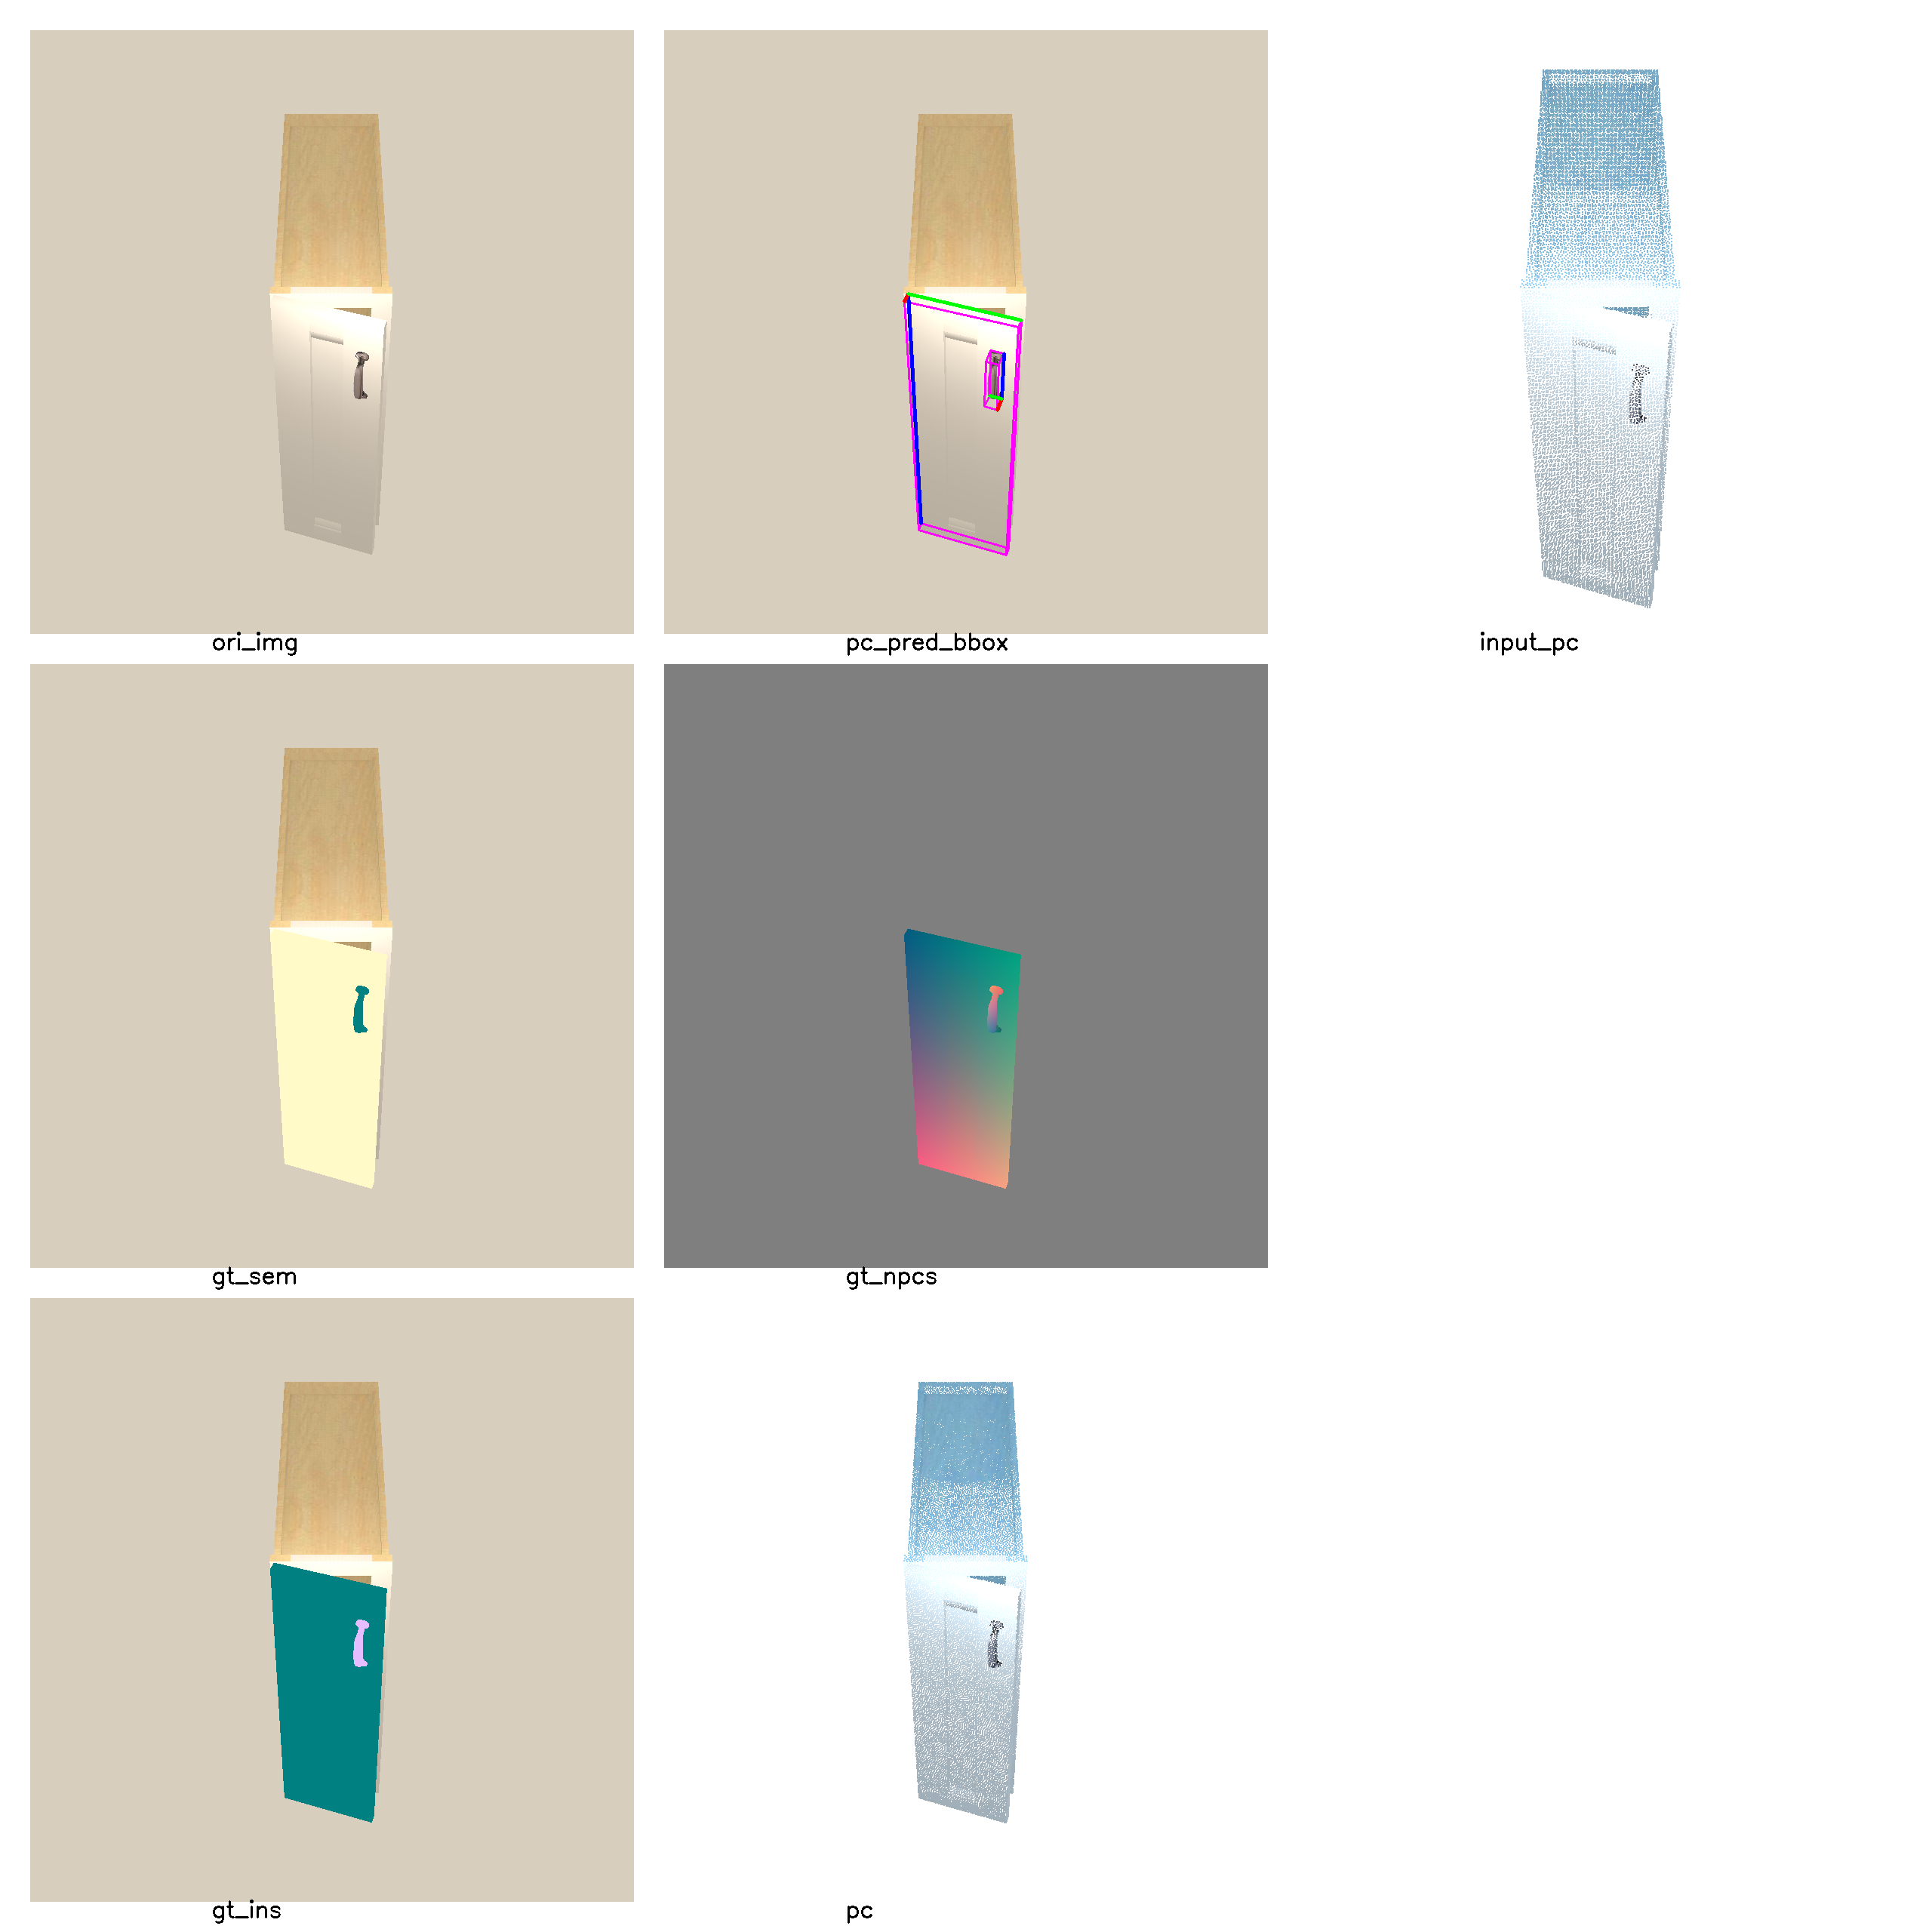

In [11]:
from PIL import Image
display(Image.fromarray((result_img).astype(np.uint8))) # visualize the result